In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import nepal_figs
import etas_analyzer

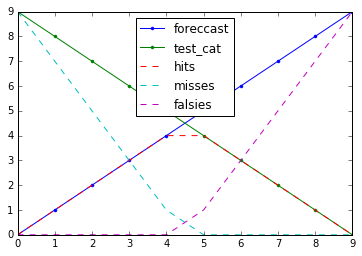

In [4]:
#aa=nepal_figs.toy_gs_roc()


In [7]:
bb=etas_analyzer.nepal_linear_roc()

TypeError: nepal_linear_roc() got an unexpected keyword argument 'diagnostic'